This notebook shows how to use [GEMDAT](https://gemdat.readthedocs.org) to compute the shortest percolating path.

It first computes the free energy on a discretized gride from the trajectory, then it finds the nearest sites of the structure to each point of the grid to map the space. The density probability is also used to initialize the percolation search. The user has then to specify in which of the cartesian directions the percolation has to happen (multiple selection is allowed). After selecting the metric for path evaluation, GEMDAT returns the best percolating path.

As input you will need:

1. [symmetrized crystal or material structure](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.structure.SymmetrizedStructure)
    - contains unique sites to act as cluster centers (asymmetic unit)
    - provides symmetry operations
    - Gemdat uses [SpacegroupAnalyzer](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer) to find symmetry in P1 structures
2. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
    - typically P1
    - maybe a supercell of the structure in #1
    - lattice can be triclinic (non-constrained in simulation)
3. discretized grid resolution
    - float value
4. pathfinding algorithm, that can be one of the following:
    - Dijkstra algorithm through [`networkx.short_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path)
    - Bellman-Ford algorithm through [`networkx.short_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path)
    - Minimal maximum energy
    - Dijkstra but with exponentially scaled energy
5. Percolation directions

The resulting path can be analyzed and plotted in 3d, together with the energy profile along the path.

In [1]:
from __future__ import annotations

import random
from pathlib import Path

import numpy as np

from gemdat import Trajectory, plots
from gemdat.io import load_known_material
from gemdat.path import find_best_perc_path, free_energy_graph
from gemdat.volume import trajectory_to_volume

In [2]:
# Fix the seed for reproducibility
random.seed(142)
np.random.seed(142)

In [3]:
# Select the trajectory to load
trajectory = Trajectory.from_vasprun(Path('../GEMDAT/tests/data/short_simulation/vasprun.xml'))
print('Loading ok', flush=True)
type_to_select = 'Li'
diff_trajectory = trajectory.filter(type_to_select)

Loading ok


In [4]:
resolution = 0.45
# Resolution is the minimum size of the voxels in Angstrom
diff_volume = trajectory_to_volume(diff_trajectory, resolution=resolution)

# then you can get the free energy
F = diff_volume.get_free_energy(temperature=trajectory.metadata['temperature'])
# *Notice that there are points where it is numerically impossible to find moble atoms
# In such points the free energy is Inf and it can cause numerical instabilities

# Compute the free enrgy graph using networkx
F_graph = free_energy_graph(F, max_energy_threshold=1e7, diagonal=True)

/home/simone/Dropbox/eScience_projects/GEMDAT-repos/GEMDAT/src/gemdat/volume.py:352: RuntimeWarning: divide by zero encountered in log
  'Boltzmann constant in eV/K'][0] * np.log(prob)


Find the peaks of the density, that will be used as guessed starting points for the percolating path

In [5]:
peaks = diff_volume.find_peaks()

In [6]:
# Load the reference structure
structure = load_known_material('argyrodite', supercell=(2, 1, 1))

# and use it to map the voxel volume to the closest site of the structure
diff_volume.nearest_structure_reference(structure)

In [7]:
# Look for the lowest-energy path that percolates the system.
# It is possible to set in which direction(s) the path has to percolate, with the `percolate_i` flags.

best_perc_path = find_best_perc_path(
    F, peaks, percolate_x=True, percolate_y=False, percolate_z=False
)

print(f'Total Energy required: {np.sum(best_perc_path.energy)}')
print(f'Starting Point: {best_perc_path.sites[0]}')
print(f'Best Path: {best_perc_path.sites}')
print(f'Best Path Energy: {best_perc_path.energy}')

Total Energy required: 20.809283093324538
Starting Point: (18, 15, 10)
Best Path: [(18, 15, 10), (17, 16, 10), (16, 17, 10), (15, 17, 10), (14, 17, 10), (13, 17, 9), (12, 17, 9), (11, 17, 10), (10, 17, 11), (9, 17, 12), (8, 17, 12), (7, 17, 12), (6, 16, 11), (5, 15, 10), (4, 14, 9), (3, 13, 8), (2, 13, 7), (1, 14, 7), (0, 15, 7), (87, 14, 7), (86, 13, 6), (85, 12, 6), (84, 11, 6), (83, 10, 5), (82, 9, 5), (81, 9, 4), (80, 10, 4), (79, 11, 4), (78, 11, 5), (77, 10, 5), (76, 9, 5), (75, 9, 4), (74, 9, 4), (73, 10, 4), (72, 11, 5), (71, 11, 6), (70, 11, 7), (69, 12, 7), (68, 13, 8), (67, 14, 8), (66, 15, 9), (65, 16, 9), (64, 15, 9), (63, 15, 10), (62, 15, 10)]
Best Path Energy: [0.3469418277479522, 0.4365220749175937, 0.4444071209886786, 0.39360672075132086, 0.38463524190083387, 0.3722260686844244, 0.4281306897840608, 0.693906989245962, 0.5708345824226004, 0.42961128698887746, 0.42911339334429927, 0.47707069921726203, 0.5649330590280827, 0.4858999166528686, 0.4484579940653183, 0.50156021

/tmp/ipykernel_33063/1913151382.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



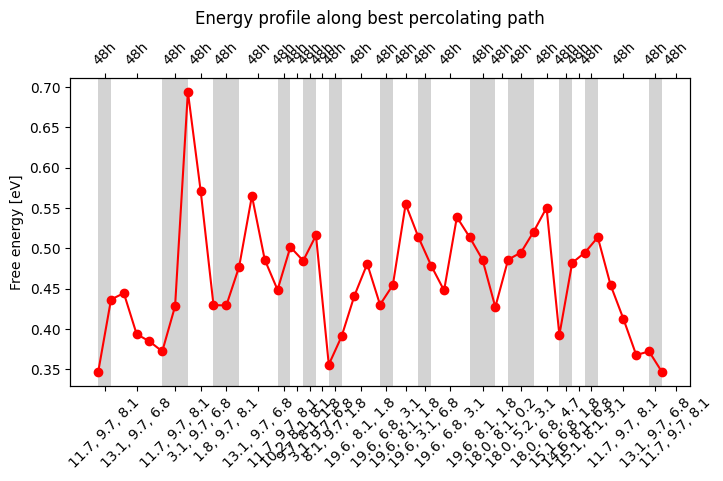

In [8]:
# Plot the best percolating path
wrapped_path = best_perc_path
wrapped_path.wrap(F)
wrapped_path.cartesian_path(diff_volume)
wrapped_path.fractional_path(diff_volume)
fig1 = plots.path_on_landscape(diff_volume, wrapped_path, structure)
fig1.update_layout(title=f'Best percolating path starts in {wrapped_path.sites[0]}')
fig1.show()

wrapped_path.path_over_structure(structure, diff_volume)
fig2 = plots.energy_along_path(path=wrapped_path)
fig2.suptitle('Energy profile along best percolating path', y=1.05)
fig2.show()